In [22]:
import liana 
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import anndata
import scanpy as sc
from liana.mt import rank_aggregate
from liana.mt import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import numpy as np
from matplotlib.pyplot import figure
import math
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.gridspec as grid_spec

%matplotlib inline

# Data PreProcessing

# Mouse Dataset 

In [23]:
matrix = pd.read_csv("../../data/CellGATv2_Input/Mouse/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_57272/3141878082.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/tmp/ipykernel_57272/3141878082.py:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [24]:
cellphonedb(adata,groupby="label",expr_prop=0.05)
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)

In [25]:
connectome(adata,groupby="label",expr_prop=0.03)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)

In [26]:
cellchat(adata,groupby="label",expr_prop=0.01)
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

## load data trained on the full Omnipath set, and just the LIANA consensus

In [125]:
consensus_data=pd.read_csv("../../data/CellGATv2_Output/consensus_Mouse/CCI.csv")
input_data=pd.read_csv("../../data/CellGATv2_Output/Mouse/CCI.csv")
full_input_data = input_data.copy()

## identify overlapping interactions across all validated interactions from CellGATv2 results & other methods

In [126]:
connectome_df = connectome_df[["ligand","receptor","expr_prod"]][["ligand","receptor"]]
cellchat_df = cellchat_df[["ligand","receptor","lr_probs"]][["ligand","receptor"]]
cellphone_df = cellphone_df[["ligand","receptor","lr_means"]][["ligand","receptor"]]

In [127]:
connectome_df = connectome_df.drop_duplicates(["ligand","receptor"],keep="first")
cellchat_df = cellchat_df.drop_duplicates(["ligand","receptor"],keep="first")
cellphone_df = cellphone_df.drop_duplicates(["ligand","receptor"],keep="first")

In [128]:
full_connectome_df = connectome_df.copy()
full_cellchat_df = cellchat_df.copy()
full_cellphone_df = cellphone_df.copy()

In [129]:
intercell = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv",index_col=0)
intercell.columns = ["source","target"]

In [130]:
consensus_data=pd.merge(consensus_data,intercell,left_on=["Src","Dst"],right_on=["source","target"])
input_data=pd.merge(input_data,intercell,left_on=["Src","Dst"],right_on=["source","target"])
connectome_df=pd.merge(connectome_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])
cellchat_df=pd.merge(cellchat_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])
cellphone_df=pd.merge(cellphone_df,intercell,left_on=["ligand","receptor"],right_on=["source","target"])

In [131]:
full_connectome_df = connectome_df.copy()
full_cellchat_df = cellchat_df.copy()
full_cellphone_df = cellphone_df.copy()
full_input_data = input_data.copy()
full_consensus_df = consensus_data.copy()

In [132]:
truth = pd.read_csv("../../data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [133]:
new_consensus_data=pd.merge(consensus_data,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])
new_input_data=pd.merge(input_data,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])
new_connectome_df=pd.merge(connectome_df,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
new_cellchat_df=pd.merge(cellchat_df,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])
new_cellphone_df=pd.merge(cellphone_df,truth,left_on=["ligand","receptor"],right_on=["Ligand","Receptor"])

In [134]:
#consensus_shape = new_consensus_data.shape[0]/consensus_data.shape[0]
input_shape = new_input_data.shape[0]/input_data.shape[0]

connectome_shape = new_connectome_df.shape[0]/connectome_df.shape[0]
cellchat_shape = new_cellchat_df.shape[0]/cellchat_df.shape[0]
cellphone_shape = new_cellphone_df.shape[0]/cellphone_df.shape[0]

In [135]:
new_input_data

,Unnamed: 0,Src,Dst,Prob,source,target,Ligand,Receptor
0,5224837,TGFB1,ACVRL1,0.729605,TGFB1,ACVRL1,TGFB1,ACVRL1
1,1157348,L1CAM,EGFR,0.700125,L1CAM,EGFR,L1CAM,EGFR
2,1425229,APP,GPC1,0.653958,APP,GPC1,APP,GPC1
3,3140705,COL18A1,GPC1,0.653541,COL18A1,GPC1,COL18A1,GPC1
4,2180648,LAMA1,GPC1,0.653356,LAMA1,GPC1,LAMA1,GPC1
...,...,...,...,...,...,...,...,...
192,1358741,TFPI,VLDLR,0.286062,TFPI,VLDLR,TFPI,VLDLR
193,5107535,LPL,VLDLR,0.285969,LPL,VLDLR,LPL,VLDLR
194,331197,LRPAP1,VLDLR,0.285876,LRPAP1,VLDLR,LRPAP1,VLDLR
195,4032870,NCAN,CDH2,0.194076,NCAN,CDH2,NCAN,CDH2


In [136]:
new_cellchat_df

,ligand,receptor,source,target,Ligand,Receptor
0,COL4A1,CD93,COL4A1,CD93,COL4A1,CD93
1,COL4A2,CD93,COL4A2,CD93,COL4A2,CD93
2,VTN,KDR,VTN,KDR,VTN,KDR
3,C1QA,CD93,C1QA,CD93,C1QA,CD93
4,IGF2,IGF1R,IGF2,IGF1R,IGF2,IGF1R
...,...,...,...,...,...,...
206,SLIT2,GPC1,SLIT2,GPC1,SLIT2,GPC1
207,EFNA5,EPHA3,EFNA5,EPHA3,EFNA5,EPHA3
208,CNTN2,NRCAM,CNTN2,NRCAM,CNTN2,NRCAM
209,EFNA4,EPHA3,EFNA4,EPHA3,EFNA4,EPHA3


Text(0, 0.5, 'Fraction of consensus interactions')

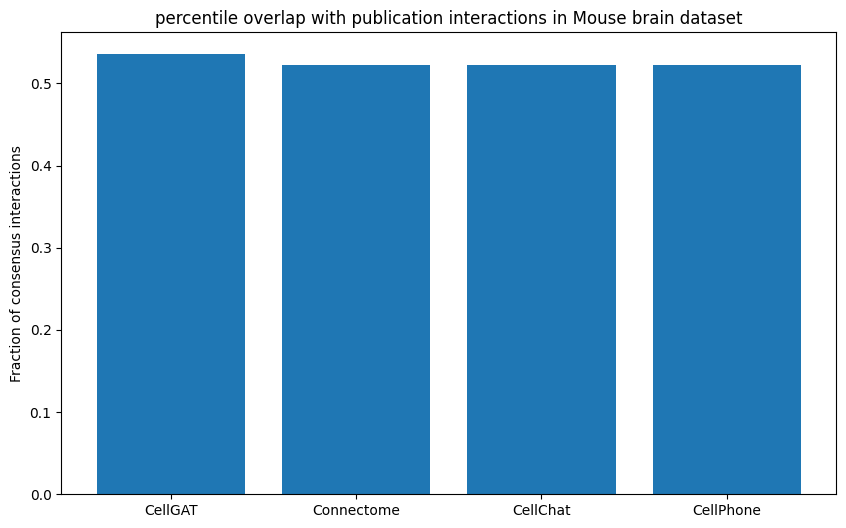

In [165]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.bar(["CellGAT","Connectome","CellChat","CellPhone"],[input_shape,connectome_shape,cellchat_shape,cellphone_shape])

plt.title("percentile overlap with publication interactions in Mouse brain dataset")
plt.ylabel("Fraction of consensus interactions")

In [61]:
filtered_connectome_df = pd.merge(new_connectome_df, full_connectome_df, on=['ligand','receptor'], how='outer', indicator=True)
filtered_cellphone_df = pd.merge(new_cellphone_df, full_cellphone_df, on=['ligand','receptor'], how='outer', indicator=True)
filtered_cellchat_df = pd.merge(new_cellchat_df, full_cellchat_df, on=['ligand','receptor'], how='outer', indicator=True)
filtered_input_df = pd.merge(new_input_data, full_input_data, on=['Src','Dst'], how='outer', indicator=True)
#filtered_consensus_df = pd.merge(new_consensus_data, full_input_data, on=['Src','Dst'], how='outer', indicator=True)

In [62]:
filtered_connectome_df = filtered_connectome_df[filtered_connectome_df["_merge"]=="right_only"][["ligand","receptor"]]
filtered_cellchat_df = filtered_cellchat_df[filtered_cellchat_df["_merge"]=="right_only"][["ligand","receptor"]]
filtered_cellphone_df = filtered_cellphone_df[filtered_cellphone_df["_merge"]=="right_only"][["ligand","receptor"]]
filtered_input_df = filtered_input_df[filtered_input_df["_merge"]=="right_only"][["Src","Dst"]]
#filtered_consensus_df = filtered_consensus_df[filtered_consensus_df["_merge"]=="right_only"][["Src","Dst"]]

## Day 0

In [80]:
matrix = pd.read_csv("../../data/CellGATv2_Input/Pre_Post/Day0/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

/tmp/ipykernel_37122/3990631905.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_37122/3990631905.py:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [81]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

In [82]:
day0_list = [connectome_df,cellphone_df,cellchat_df]

## Day 7 - replicate 1

In [83]:
matrix = pd.read_csv("../../data/CellGATv2_Input/Pre_Post/Day7_1/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())

sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_37122/4282893567.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/tmp/ipykernel_37122/4282893567.py:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [84]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

In [85]:
day7_rep1_list = [connectome_df,cellphone_df,cellchat_df]

## Day 7 - replicate 2

In [86]:
matrix = pd.read_csv("../../data/CellGATv2_Input/Pre_Post/Day7_2/matrix.csv",index_col=0)

matrix.index = [str(i).upper() for i in matrix.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

matrix = matrix.fillna(0)

adata = anndata.AnnData(matrix.transpose())


sc.pp.normalize_total(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})

meta.index = meta["cell"].tolist()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')
pval_df = pd.DataFrame.from_records(adata.uns["rank_genes_groups"]["pvals"])
pval_df.index = matrix.index.tolist()
cell_type_df = {}
for i in pval_df.columns.tolist():
    sub = pval_df[i]
    sub = sub[sub < 0.05]
    cell_type_df[i] = sub.index.tolist()

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_37122/1007974555.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/tmp/ipykernel_37122/1007974555.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [87]:
connectome(adata,groupby="label",expr_prop=0)
connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label")
cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label")
cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

In [88]:
day7_rep2_list = [connectome_df,cellphone_df,cellchat_df]

### pathway analysis

In [89]:
pathways = pd.read_csv("../../data/LR_database/kegg_pathways.csv")

In [90]:
Omnipath_db = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv",index_col=0)[["source","target"]].drop_duplicates()
Omnipath_db.columns = ["from","to"]
Omnipath_db = Omnipath_db.drop_duplicates()

In [91]:
day0_list = [i[(i["ligand"].isin(Omnipath_db["from"].tolist()))&(i["receptor"].isin(Omnipath_db["to"].tolist()))] for i in day0_list]
day7_rep1_list = [i[(i["ligand"].isin(Omnipath_db["from"].tolist()))&(i["receptor"].isin(Omnipath_db["to"].tolist()))] for i in day7_rep1_list]
day7_rep2_list = [i[(i["ligand"].isin(Omnipath_db["from"].tolist()))&(i["receptor"].isin(Omnipath_db["to"].tolist()))] for i in day7_rep2_list]

In [92]:
total_day7_1 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day0/CCI.csv")[["Src","Dst"]]
total_day7_2 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_1/CCI.csv")[["Src","Dst"]]
total_day0 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_2/CCI.csv")[["Src","Dst"]]

total_day7_1 = total_day7_1[(total_day7_1["Src"].isin(Omnipath_db["from"].tolist()))&(total_day7_1["Dst"].isin(Omnipath_db["to"].tolist()))]
total_day7_2 = total_day7_2[(total_day7_2["Src"].isin(Omnipath_db["from"].tolist()))&(total_day7_2["Dst"].isin(Omnipath_db["to"].tolist()))]
total_day0 = total_day0[(total_day0["Src"].isin(Omnipath_db["from"].tolist()))&(total_day0["Dst"].isin(Omnipath_db["to"].tolist()))]

In [93]:
pathways.index = pathways["genesymbol"].tolist()

In [94]:
day0_list = [i[(i["ligand"].isin(pathways["genesymbol"].tolist()))&(i["receptor"].isin(pathways["genesymbol"].tolist()))] for i in day0_list]
day7_rep1_list = [i[(i["ligand"].isin(pathways["genesymbol"].tolist()))&(i["receptor"].isin(pathways["genesymbol"].tolist()))] for i in day7_rep1_list]
day7_rep2_list = [i[(i["ligand"].isin(pathways["genesymbol"].tolist()))&(i["receptor"].isin(pathways["genesymbol"].tolist()))] for i in day7_rep2_list]

In [95]:
total_day7_1 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day0/CCI.csv")[["Src","Dst"]]
total_day7_2 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_1/CCI.csv")[["Src","Dst"]]
total_day0 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_2/CCI.csv")[["Src","Dst"]]

total_day7_1 = total_day7_1[(total_day7_1["Src"].isin(pathways["genesymbol"].tolist()))&(total_day7_1["Dst"].isin(pathways["genesymbol"].tolist()))]
total_day7_2 = total_day7_2[(total_day7_2["Src"].isin(pathways["genesymbol"].tolist()))&(total_day7_2["Dst"].isin(pathways["genesymbol"].tolist()))]
total_day0 = total_day0[(total_day0["Src"].isin(pathways["genesymbol"].tolist()))&(total_day0["Dst"].isin(pathways["genesymbol"].tolist()))]

In [96]:
pathways = pathways.drop_duplicates("genesymbol")
pathways.index = pathways["genesymbol"].tolist()

In [97]:
for i in day0_list:
    i["Ligand Pathway"] = pathways.loc[i["ligand"].tolist()]["pathway"].tolist()
    i["Receptor Pathway"] = pathways.loc[i["receptor"].tolist()]["pathway"].tolist()

In [98]:
for i in day7_rep1_list:
    i["Ligand Pathway"] = pathways.loc[i["ligand"].tolist()]["pathway"].tolist()
    i["Receptor Pathway"] = pathways.loc[i["receptor"].tolist()]["pathway"].tolist()

In [99]:
for i in day7_rep2_list:
    i["Ligand Pathway"] = pathways.loc[i["ligand"].tolist()]["pathway"].tolist()
    i["Receptor Pathway"] = pathways.loc[i["receptor"].tolist()]["pathway"].tolist()

In [100]:
total_day0["Ligand Pathway"] = pathways.loc[total_day0["Src"].tolist()]["pathway"].tolist()
total_day0["Receptor Pathway"] = pathways.loc[total_day0["Dst"].tolist()]["pathway"].tolist()

In [101]:
total_day7_1["Ligand Pathway"] = pathways.loc[total_day7_1["Src"].tolist()]["pathway"].tolist()
total_day7_1["Receptor Pathway"] = pathways.loc[total_day7_1["Dst"].tolist()]["pathway"].tolist()

In [102]:
total_day7_2["Ligand Pathway"] = pathways.loc[total_day7_2["Src"].tolist()]["pathway"].tolist()
total_day7_2["Receptor Pathway"] = pathways.loc[total_day7_2["Dst"].tolist()]["pathway"].tolist()

In [103]:
day0_list = [i.head(1000) for i in day0_list]
day7_rep1_list = [i.head(1000) for i in day7_rep1_list]
day7_rep2_list = [i.head(1000) for i in day7_rep2_list]

In [104]:
total_day0 = total_day0.head(1000)
total_day7_1 = total_day7_1.head(1000)
total_day7_2 = total_day7_2.head(1000)

In [105]:
grouped_day_7_1_list = [i.groupby("Receptor Pathway").count().sort_values("ligand",ascending=False) for i in day7_rep2_list]
grouped_day_7_1 = total_day7_2.groupby("Receptor Pathway").count().sort_values("Src",ascending=False)

In [106]:
grouped_day_7_1_list[0].to_csv("../../results/connectome_day7_2_receptor.csv")

In [107]:
grouped_day_7_1_list[1].to_csv("../../results/cellphone_day7_2_receptor.csv")

In [108]:
grouped_day_7_1_list[2].to_csv("../../results/cellchat_day7_2_receptor.csv")

In [109]:
grouped_day_7_1.to_csv("../../results/CellGATv2_day7_2_receptor.csv")

### get unique ligand receptor interactions

In [110]:
day0_list = [i[["ligand","receptor"]].drop_duplicates() for i in day0_list]
day7_rep1_list = [i[["ligand","receptor"]].drop_duplicates() for i in day7_rep1_list]
day7_rep2_list = [i[["ligand","receptor"]].drop_duplicates() for i in day7_rep2_list]

In [111]:
original_day0 = day0_list
original_day7_rep1 = day7_rep1_list
original_day7_rep2 = day7_rep2_list


### for each method's result of each dataset, retrieve the top 50 interactions

In [112]:
day0_list = [i.head(50) for i in day0_list]
day7_rep1_list = [i.head(50) for i in day7_rep1_list]
day7_rep2_list = [i.head(50) for i in day7_rep2_list]


In [113]:
pathways = pd.read_csv("../../data/LR_database/kegg_pathways.csv")

In [114]:
for i in day0_list:
    i["Ligand Pathway"] = [pathways[pathways["genesymbol"]==j]["pathway"] for j in i["ligand"].tolist()]

/tmp/ipykernel_37122/221003646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### for each method's result of each dataset, only retain intercell validated interactions

In [115]:
Omnipath_db = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv",index_col=0)[["source","target"]].drop_duplicates()
Omnipath_db.columns = ["from","to"]
Omnipath_db = Omnipath_db.drop_duplicates()

In [116]:
day0_list = [pd.merge(i,Omnipath_db,left_on=["ligand","receptor"],right_on=["from","to"]) for i in day0_list]
day7_rep1_list = [pd.merge(i,Omnipath_db,left_on=["ligand","receptor"],right_on=["from","to"]) for i in day7_rep1_list]
day7_rep2_list = [pd.merge(i,Omnipath_db,left_on=["ligand","receptor"],right_on=["from","to"]) for i in day7_rep2_list]

day0_list = [i[["ligand","receptor"]] for i in day0_list]
day7_rep1_list = [i[["ligand","receptor"]] for i in day7_rep1_list]
day7_rep2_list = [i[["ligand","receptor"]] for i in day7_rep2_list]

### for each method, capture maximum # of unique interactions between top 100 CCC interactions between pre and post treatment datasets

In [117]:
pre_post_list = []
for i,j,k in zip(day0_list,day7_rep1_list,day7_rep2_list):
    day0_day7_rep1_common = pd.merge(i,j).shape[0]/50
    day0_day7_rep2_common = pd.merge(i,k).shape[0]/50
    pre_post_list.append(min(1-day0_day7_rep1_common,1-day0_day7_rep2_common))

### import CellGATv2's results, perform same preprocessing

In [118]:
total_day7_1 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day0/CCI.csv")[["Src","Dst"]]
total_day7_2 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_1/CCI.csv")[["Src","Dst"]]
total_day0 = pd.read_csv("../../data/CellGATv2_Output/Pre_Post/Day7_2/CCI.csv")[["Src","Dst"]]

total_day0 = pd.merge(total_day0,Omnipath_db,left_on=["Src","Dst"],right_on=["from","to"]).head(50)[["Src","Dst"]]
total_day7_1 = pd.merge(total_day7_1,Omnipath_db,left_on=["Src","Dst"],right_on=["from","to"]).head(50)[["Src","Dst"]]
total_day7_2 = pd.merge(total_day7_2,Omnipath_db,left_on=["Src","Dst"],right_on=["from","to"]).head(50)[["Src","Dst"]]

In [119]:
total_day0_day7_1 = pd.merge(total_day0,total_day7_1).shape[0]/50
total_day0_day7_2 = pd.merge(total_day0,total_day7_2).shape[0]/50
total_pre_post = max(1-total_day0_day7_1,1-total_day0_day7_2)

Text(0, 0.5, 'Fraction of Unique Interactions')

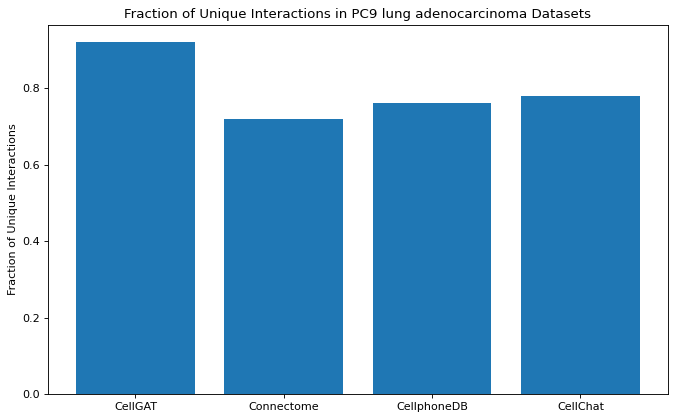

In [120]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(10,6), dpi=80)
plt.bar(["CellGAT","Connectome","CellphoneDB","CellChat"],[total_pre_post] + pre_post_list)

plt.title("Fraction of Unique Interactions in PC9 lung adenocarcinoma Datasets")
plt.ylabel("Fraction of Unique Interactions")

# Cardiac_cells(Spatial data)

In [2]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells//Visium-FZ_GT_P19.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
matrix = pd.DataFrame.sparse.from_spmatrix(adata.X,index=adata.obs.index.tolist(),columns=adata.var["feature_name"].tolist())

meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"label":adata.obs["cell_type_original"].tolist()})
meta = meta[meta["label"] != "Lymphoid"]
meta.index = meta["cell"].tolist()

matrix = matrix.transpose()

matrix = matrix[meta.index.tolist()]

from scipy.stats import wilcoxon
import anndata
import scanpy as sc

index = matrix.index.tolist()

meta['label'] = meta["label"].astype("string").tolist()

meta["cell"] = meta["cell"].astype("category")
meta["label"] = meta["label"].astype("category")

matrix = matrix.loc[:,~matrix.columns.duplicated()].copy()
meta = meta.loc[~meta.index.duplicated(),:].copy()

adata = anndata.AnnData(matrix.transpose())
adata.raw = adata
adata.obs = meta
adata.obs["label"] = adata.obs["label"].astype("category")
sc.tl.rank_genes_groups(adata, 'label')

In [3]:
connectome(adata,groupby="label",expr_prop=0.05)
spatial_connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)
cellphonedb(adata,groupby="label",expr_prop=0.03)
spatial_cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)
cellchat(adata,groupby="label",expr_prop=0.01)
spatial_cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)


### remove self-loops for cell groups

In [4]:
spatial_cellphone_df = spatial_cellphone_df[spatial_cellphone_df["source"] != spatial_cellphone_df["target"]]
spatial_cellchat_df = spatial_cellchat_df[spatial_cellchat_df["source"] != spatial_cellchat_df["target"]]
spatial_connectome_df = spatial_connectome_df[spatial_connectome_df["source"] != spatial_connectome_df["target"]]

### for each method's results, capture the top 10 unique cell group interactions

In [5]:
temp_cellphone_df = spatial_cellphone_df.drop_duplicates(["source","target"]).head(10)
temp_cellchat_df = spatial_cellchat_df.drop_duplicates(["source","target"]).head(10)
temp_connectome_df = spatial_connectome_df.drop_duplicates(["source","target"]).head(10)

### import CellGATv2 results, remove self loops and capture the top 10 unique cell group interactions

In [6]:
total_spatial = pd.read_csv("../../data/CellGATv2_Output/Cardiac_cells/FZ_GT_P19/CCI.csv",index_col=0)
total_spatial = total_spatial[total_spatial["Src Cell"] != total_spatial["Dst Cell"]]
total_spatial = total_spatial.drop_duplicates(["Src Cell","Dst Cell"]).head(10)

### retrieve cell group spatial coordinates

In [7]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")

In [8]:
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"label":adata.obs["cell_type_original"].tolist()})
meta = meta[meta["label"] != "Lymphoid"]
meta.index = meta["cell"].tolist()

adata = adata[meta.index.tolist()]
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=meta.index.tolist())
cell_groups = meta["label"].unique().tolist()

### extract from each method, the average eucleadian distance for the top 10 cell group interactions

In [9]:
cellphone_spatial = []
for one,two in zip(temp_cellphone_df["source"].tolist(),temp_cellphone_df["target"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    cellphone_spatial.append(np.mean(min_list))


In [10]:
cellchat_spatial = []
for one,two in zip(temp_cellchat_df["source"].tolist(),temp_cellchat_df["target"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    cellchat_spatial.append(np.mean(min_list))


In [11]:
connectome_spatial = []
for one,two in zip(temp_connectome_df["source"].tolist(),temp_connectome_df["target"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    connectome_spatial.append(np.mean(min_list))


In [12]:
CellGATv2_total_spatial = []
for one,two in zip(total_spatial["Src Cell"].tolist(),total_spatial["Dst Cell"].tolist()):
    cells = meta[meta["label"]==one].index.tolist()
    spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
    second_cells = meta[meta["label"]==two].index.tolist()
    second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
    min_list = []
    for k in spatial_coords:
        min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
    CellGATv2_total_spatial.append(np.mean(min_list))


In [13]:
x = [connectome_spatial,cellchat_spatial,cellphone_spatial,CellGATv2_total_spatial,]
comparison_labels = ['Connectome',"CellChat","CellponeDB","CellGAT"]
df = pd.DataFrame(x, index=comparison_labels)


### visualize via ridgeline plot

In [14]:
df

,0,1,2,3,4,5,6,7,8,9
Connectome,0.508076,0.579552,0.437746,0.513490,0.433397,0.437746,0.484351,0.511083,0.496317,0.385759
CellChat,0.579552,0.508076,0.437746,0.513490,0.433397,0.511083,0.484351,0.475336,0.496317,0.385759
CellponeDB,0.508076,0.579552,0.437746,0.385759,0.484351,0.511083,0.433397,0.437746,0.417550,0.475336
CellGAT,0.523165,0.467333,0.523165,0.496317,0.508076,0.439119,0.467333,0.496317,0.439119,0.508076


In [15]:
df.var(axis=1)

Connectome    0.003076
CellChat      0.002874
CellponeDB    0.003173
CellGAT       0.001004
dtype: float64

In [16]:
df.mean(axis=1)

Connectome    0.478752
CellChat      0.482511
CellponeDB    0.467060
CellGAT       0.486802
dtype: float64

In [17]:
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

In [18]:
CellGATv2_total_df = pd.DataFrame([CellGATv2_total_spatial], index=["CellGATv2"]).transpose()
connectome_df= pd.DataFrame([connectome_spatial], index=["Connectome"]).transpose()
cellchat_df= pd.DataFrame([cellchat_spatial], index=["CellChat"]).transpose()
cellphone_df= pd.DataFrame([cellphone_spatial], index=["CellPhone"]).transpose()

In [19]:
df_list = [connectome_df,cellchat_df,cellphone_df,CellGATv2_total_df]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


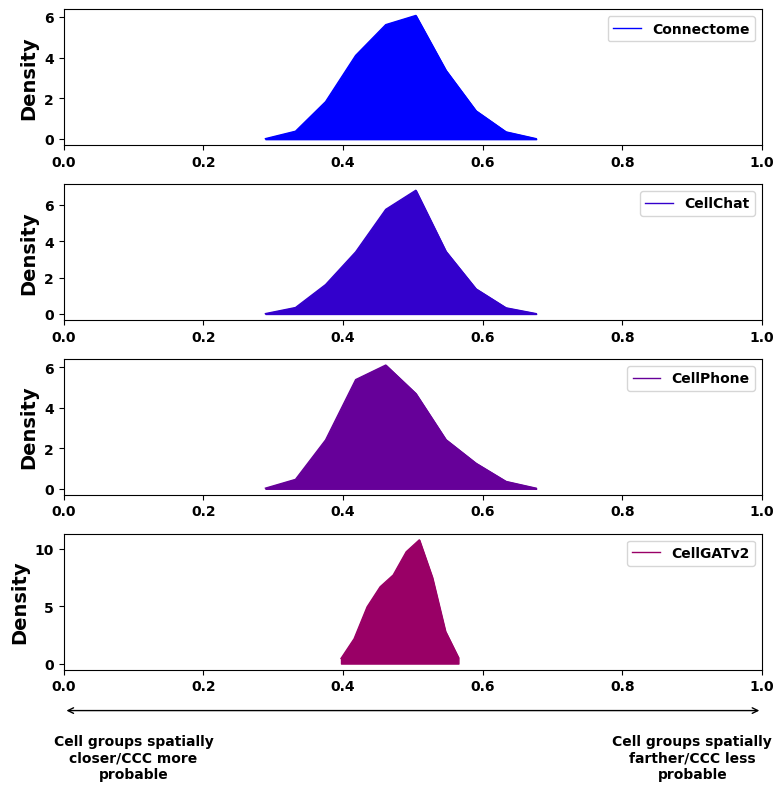

In [31]:
import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体属性
rcParams['font.weight'] = 'bold'

gs = (grid_spec.GridSpec(len(comparison_labels), 1))

fig = plt.figure(figsize=(8, 8))

ax_objs = []

for df, label in zip(df_list, comparison_labels):
    ax_objs.append(fig.add_subplot(gs[len(ax_objs):len(ax_objs) + 1, 0:]))

    plot = df.plot.kde(ax=ax_objs[-1], color=colors[len(ax_objs) - 1], lw=1, ind=10)
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    plot.legend()
    ax_objs[-1].fill_between(x, y, color=colors[len(ax_objs) - 1])
    ax_objs[-1].set_xlim(0, 1)
    ax_objs[-1].set_ylabel('Density', fontsize=14)

    # 设置纵轴标签字体
font = FontProperties()
font.set_family('Arial')
font.set_weight('bold')
for ax in ax_objs:
    ax.set_ylabel('Density', fontsize=14, fontproperties=font)

    
plt.annotate('', xy=(0, -0.3), xycoords='axes fraction', xytext=(1, -0.3),
             arrowprops=dict(arrowstyle="<->"))
plt.text(0.1, -10, 'Cell groups spatially\ncloser/CCC more\nprobable', ha="center")
plt.text(0.9, -10, 'Cell groups spatially\nfarther/CCC less\nprobable', ha="center")

plt.tight_layout()
plt.savefig('../../results/Cardiac_1_compare.png', dpi=300)
plt.show()
